# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [3]:
import os
os.getcwd()

'/scratch/hpda/indycar/indycar_rankpred/data_preparation'

In [22]:
final_lap = 200

total_laps = final_lap + 1

dataset = pd.read_csv('completed_laps.csv')

# get records for the cars that finish the race
completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values

completed_car_count = len(completed_car_numbers)

print('count of completed cars:', completed_car_count)
print('completed cars:', completed_car_numbers)

#make a copy
alldata = dataset.copy()
dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]

count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


In [6]:
dataset.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True).head(40)

,command,type,sequence_number,preamble,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
9,$C,U,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
42,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
75,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
108,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
141,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
174,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
207,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
240,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
273,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0
306,$C,R,196608,R.I,4,1,3,0,0.000000,0.000000,...,0.000000,0,4,0.000000,Active,U,0,0,4,0


In [7]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10725 entries, 0 to 19424
Data columns (total 25 columns):
command                 10725 non-null object
type                    10725 non-null object
sequence_number         10725 non-null int64
preamble                10725 non-null object
rank                    10725 non-null int64
car_number              10725 non-null int64
unique_id               10725 non-null int64
completed_laps          10725 non-null int64
elapsed_time            10725 non-null float64
last_laptime            10725 non-null float64
lap_status              10725 non-null object
best_laptime            10725 non-null float64
best_lap                10725 non-null int64
time_behind_leader      10725 non-null float64
laps_behind_leader      10725 non-null int64
time_behind_prec        10725 non-null float64
laps_behind_prec        10725 non-null int64
overall_rank            10725 non-null int64
overall_best_laptime    10725 non-null float64
current_status      

## Prepare data for RNN

In [8]:
#univariate dataset
uni_ds = dataset.drop(["command", "type", "sequence_number",
                       "unique_id", "preamble", "current_status", "track_status", "lap_status"], axis=1)
uni_ds=uni_ds.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)
uni_ds=uni_ds.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

# convert time to minutes
uni_ds.head(10)

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,best_lap,time_behind_leader,laps_behind_leader,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,pit_stop_count,last_pitted_lap,start_position,laps_led
9,4,1,0,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,4,0.000000,0,0,4,0
965,4,1,1,0.713048,0.706132,0.706132,1,0.014095,0,0.009462,0,4,0.706132,0,0,4,0
1076,4,1,2,1.398022,0.684973,0.684973,2,0.019492,0,0.010753,0,4,0.684973,0,0,4,0
1159,4,1,3,2.082927,0.684905,0.684905,3,0.024285,0,0.007620,0,4,0.684905,0,0,4,0
1239,4,1,4,2.768227,0.685300,0.684905,3,0.028913,0,0.008057,0,4,0.684905,0,0,4,0
1321,4,1,5,3.452755,0.684528,0.684528,5,0.031743,0,0.012747,0,4,0.684528,0,0,4,0
1402,4,1,6,4.139205,0.686450,0.684528,5,0.036707,0,0.013942,0,4,0.684528,0,0,4,0
1486,4,1,7,4.826953,0.687748,0.684528,5,0.042288,0,0.013360,0,4,0.684528,0,0,4,0
1571,4,1,8,5.515973,0.689020,0.684528,5,0.049047,0,0.015957,0,4,0.684528,0,0,4,0
1657,4,1,9,6.205380,0.689407,0.684528,5,0.052323,0,0.020608,0,4,0.684528,0,0,4,0


In [10]:
carnumber = uni_ds.drop_duplicates(subset=['car_number'], keep='first')
carnumber

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,best_lap,time_behind_leader,laps_behind_leader,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,pit_stop_count,last_pitted_lap,start_position,laps_led
9,4,1,0,0.0,0.0,0.0,0,0.0,0,0.0,0,4,0.0,0,0,4,0
16,11,4,0,0.0,0.0,0.0,0,0.0,0,0.0,0,11,0.0,0,0,11,0
23,18,6,0,0.0,0.0,0.0,0,0.0,0,0.0,0,18,0.0,0,0,18,0
0,1,9,0,0.0,0.0,0.0,0,0.0,0,0.0,0,1,0.0,0,0,1,0
8,3,12,0,0.0,0.0,0.0,0,0.0,0,0.0,0,3,0.0,0,0,3,0
35,30,15,0,0.0,0.0,0.0,0,0.0,0,0.0,0,30,0.0,0,0,30,0
6,1,20,0,0.0,0.0,0.0,0,0.0,0,0.0,0,1,0.0,0,0,1,0
7,2,22,0,0.0,0.0,0.0,0,0.0,0,0.0,0,2,0.0,0,0,2,0
20,15,23,0,0.0,0.0,0.0,0,0.0,0,0.0,0,15,0.0,0,0,15,0
28,23,25,0,0.0,0.0,0.0,0,0.0,0,0.0,0,23,0.0,0,0,23,0


In [11]:
uni_ds.describe()

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,best_lap,time_behind_leader,laps_behind_leader,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,pit_stop_count,last_pitted_lap,start_position,laps_led
count,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.0,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000
mean,12.644555,33.166667,100.000000,87.242162,0.895115,0.677252,51.385019,0.249478,0.030127,0.024414,0.0,12.644555,0.677252,2.922056,84.026258,16.720011,4.432559
std,7.461428,28.380850,58.031004,53.211191,0.376445,0.048661,47.702749,0.202704,0.170961,0.051348,0.0,7.461428,0.048661,1.924625,56.844521,10.091390,13.961696
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,12.000000,50.000000,37.801928,0.691965,0.675410,17.000000,0.081845,0.000000,0.007072,0.0,6.000000,0.675410,1.000000,35.000000,9.000000,0.000000
50%,13.000000,24.000000,100.000000,87.608857,0.701815,0.678670,37.000000,0.214938,0.000000,0.012672,0.0,13.000000,0.678670,3.000000,92.000000,16.500000,0.000000
75%,18.000000,60.000000,150.000000,132.526978,0.928400,0.683638,45.000000,0.380397,0.000000,0.024082,0.0,18.000000,0.683638,4.000000,130.000000,26.000000,1.000000
max,32.000000,98.000000,200.000000,180.402518,3.122488,0.761940,199.000000,1.967568,1.000000,1.561860,0.0,32.000000,0.761940,8.000000,197.000000,32.000000,65.000000


count    3618.000000
mean        0.895322
std         0.376382
min         0.000000
25%         0.691965
50%         0.701857
75%         0.928400
max         3.122488
Name: elapsed_time, dtype: float64


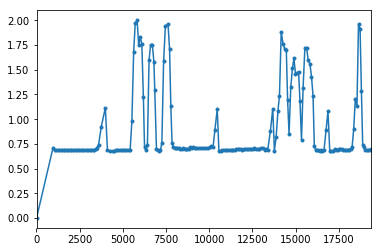

In [17]:

time_diff = uni_ds.diff(axis = 0, periods = 1)['elapsed_time']
time_diff[time_diff < 0] = 0

time_diff = time_diff.fillna(0)

print(time_diff.describe())

time_diff[:201].plot(marker='.')

In [20]:
time_diff[:10]

9       0.000000
965     0.713048
1076    0.684973
1159    0.684905
1239    0.685300
1321    0.684528
1402    0.686450
1486    0.687748
1571    0.689020
1657    0.689407
Name: elapsed_time, dtype: float64

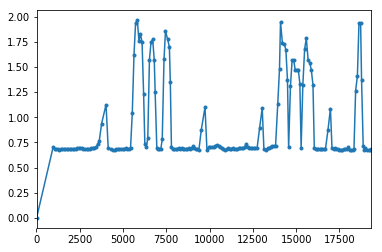

In [19]:
time_diff[uni_ds['car_number'] == 12].plot(marker='.')

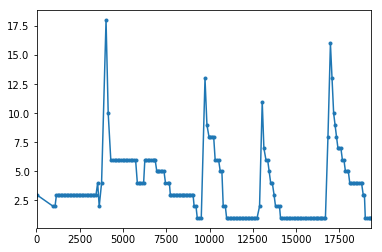

In [18]:
uni_ds[uni_ds['car_number'] == 12]['rank'].plot(marker='.') 

In [ ]:
# check the car with crash
car13 = alldata[alldata['car_number']==13]
car13

In [43]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):
    uni_ds = dataset.drop(["command", "type", "sequence_number",
                       "unique_id", "preamble", "current_status", "track_status", "lap_status"], axis=1)
    uni_ds=uni_ds.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)
    uni_ds=uni_ds.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    carnumber = set(uni_ds['car_number'])
       
    
    # time diff
    time_diff = uni_ds.diff(axis = 0, periods = 1)['elapsed_time']
    time_diff[time_diff < 0] = 0
    time_diff = time_diff.fillna(0)

    print('cars:', carnumber)
    # car by car
    rank_diff = []
    for car in carnumber:
        thiscar = uni_ds[uni_ds['car_number']==car]
        diff = thiscar.diff(axis = 0, periods = 1)['rank']
        diff = diff.fillna(0)
        rank_diff.extend(diff)
        
    
    df = pd.DataFrame({'car_number':uni_ds['car_number'], 'lap_number':uni_ds['completed_laps'], 
                       'rank':uni_ds['rank'], 'elapsed_time':uni_ds['elapsed_time'],
                       'rank_diff':rank_diff, 'time_diff':time_diff})
    
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df


In [45]:
cldata = make_cl_data(dataset)
cldata.to_csv('completed_laps_diff.csv')

cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}


/scratch/hpda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
cldata = make_cl_data(alldata)
cldata.to_csv('all_completed_laps_diff.csv')

cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}


/scratch/hpda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Prediction Variables

In [6]:
n_steps = 5

f_steps = 1

num_features = len(uni_ds.columns.values) -1

## Prepare Trainining data


### batches are cars: each batch contains same laps' data


__batch_9:__  
[c1_lap_10,  
 c2_lap_10,  
 ..  
 c30_lap_10]
 
__batch_10:__  
[c1_lap_11,  
 c2_lap_11,  
 ..  
 c30_lap_11]

In [7]:
input_data = np.empty((0, n_steps, num_features), np.float64)
output_data = np.empty((0, n_steps,1), np.float64)


car_datas = []

for car_num in completed_car_numbers:
    car_datas.append(uni_ds[uni_ds['car_number'] == car_num].drop(["car_number"], axis=1).values)
    

    
for i in range(n_steps, len(car_datas[0]) - f_steps):
    
    for c in range(completed_car_count):
        sample_input = car_datas[c][i-n_steps:i].reshape(1, n_steps, num_features)
        sample_output = car_datas[c][i-n_steps + f_steps:i+ f_steps, 2].reshape((1,n_steps,1))
        
        
        input_data = np.append(input_data, sample_input, axis=0)
        output_data = np.append(output_data, sample_output, axis=0)
    


print(input_data.shape)
print(output_data.shape)


train_ratio = 0.8

num_train = np.floor(input_data.shape[0] * 0.8).astype('i8')

train_X, train_y = input_data[:num_train], output_data[:num_train]

(3510, 5, 16)
(3510, 5, 1)


### same with the above, just each sample padded to 200. (Each sample contains all previous data)

time_step : 200 (if less, padded)

__batch_9:__  
[c1_lap_10,  
 c2_lap_10,  
 ..  
 c30_lap_10]
 
__batch_10:__  
[c1_lap_11,  
 c2_lap_11,  
 ..  
 c30_lap_11]

In [8]:
# padded to 200 timesteps

input_data = np.empty((0, 200, num_features), np.float64)
output_data = np.empty((0, 200,1), np.float64)


car_datas = []

for car_num in completed_car_numbers:
    car_datas.append(uni_ds[uni_ds['car_number'] == car_num].drop(["car_number"], axis=1).values)
    

    
for i in range(1, len(car_datas[0]) - f_steps):
    
    for c in range(completed_car_count):
        sample_input = np.zeros((1,200,num_features))
        sample_input[0,200-i:200,:] = car_datas[c][0:i].reshape(1, i, num_features)
        
        sample_output = np.zeros((1,200,1))
        sample_output[0,200-i:200,:] = car_datas[c][0 + f_steps:i + f_steps,2].reshape(1, i, 1)
        
        
        input_data = np.append(input_data, sample_input, axis=0)
        output_data = np.append(output_data, sample_output, axis=0)
    


print(input_data.shape)
print(output_data.shape)


train_ratio = 0.8

num_train = np.floor(input_data.shape[0] * 0.8).astype('i8')

train_X, train_y = input_data[:num_train], output_data[:num_train]

(3582, 200, 16)
(3582, 200, 1)


### samples sorted by car:
[c1_lap_10,  
 c1_lap_11,  
 ..  
 c1_lap_199,  
 c2_lap_10  
 ...  
]

In [9]:
train_input_data = np.empty((0, n_steps, num_features), np.float64)
train_output_data = np.empty((0, n_steps,1), np.float64)

whole_input_data = np.empty((0, n_steps, num_features), np.float64)
whole_output_data = np.empty((0, n_steps,1), np.float64)


for car_num in completed_car_numbers:
    car_data = uni_ds[uni_ds['car_number'] == car_num].drop(["car_number"], axis=1).values
    for i in range(n_steps, len(car_datas[0]) - f_steps):

        sample_input = car_data[i-n_steps:i].reshape(1, n_steps, num_features)
        sample_output = car_data[i-n_steps + f_steps:i+ f_steps, 2].reshape((1,n_steps,1))
        
        if  i < 150:
            train_input_data = np.append(train_input_data, sample_input, axis=0)
            train_output_data = np.append(train_output_data, sample_output, axis=0)
        
        whole_input_data = np.append(train_input_data, sample_input, axis=0)
        whole_output_data = np.append(train_output_data, sample_output, axis=0)
    


print(train_input_data.shape)
print(train_output_data.shape)


(2610, 5, 16)
(2610, 5, 1)
